In [42]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.stats.api as sms

%matplotlib inline

In [39]:
df = dw.td_query('''
SELECT
    shipping_country 
    ,dim_delivery_program
    ,registered
    ,TD_TIME_FORMAT(order_time,'yyyy-MM','America/Los_Angeles') as order_month
    ,max_shipping_time_shown AS shown_ship_time
    ,CEIL((COALESCE(delivered, user_confirmed_delivery) - order_time) / (3600*24)) AS actual_ship_time
    
    ,count(m_transaction_id) AS transactions
    ,count(refunded_time) AS refunds
    ,sum(if(refund_reason_category in (20,35,38), 1, 0)) AS logistics_refund
    ,round(100*count(refunded_time)/count(m_transaction_id),2) as overall_refund_rate
    ,round(100*sum(if(refund_reason_category in (20,35,38), 1, 0))/count(m_transaction_id),2) as logistics_refund_rate
    
FROM analytics.jay_ttd_refund_analysis_2
-- WHERE 
GROUP BY 1,2,3,4,5,6
-- order by TD_TIME_FORMAT(order_time,'yyyy-MM','America/Los_Angeles') asc
'''
,job_id=714262814
                )

You can look at job id 714262814


In [40]:
df.head()

,shipping_country,dim_delivery_program,registered,order_month,shown_ship_time,actual_ship_time,transactions,refunds,logistics_refund,overall_refund_rate,logistics_refund_rate
0,US,EPC,true,2019-11,20.0,19.0,25511,519,166,2,0
1,ES,Dropship,Non Wishpost,2019-11,27.0,NaN,41370,11795,11233,28,27
2,US,FBW,Non Wishpost,2020-02,64.0,NaN,18303,165,0,0,0
3,US,Dropship,Non Wishpost,2019-12,33.0,25.0,806,56,0,6,0
4,ES,FBW,Non Wishpost,2020-01,35.0,30.0,5,0,0,0,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1239856 entries, 0 to 1239855
Data columns (total 11 columns):
shipping_country         1239850 non-null object
dim_delivery_program     1239856 non-null object
registered               1165793 non-null object
order_month              1239856 non-null object
shown_ship_time          1239850 non-null float64
actual_ship_time         1178140 non-null float64
transactions             1239856 non-null int64
refunds                  1239856 non-null int64
logistics_refund         1239856 non-null int64
overall_refund_rate      1239856 non-null int64
logistics_refund_rate    1239856 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 104.1+ MB


In [70]:
df.loc[:, 'time_diff'] = df.actual_ship_time - df.shown_ship_time
df.loc[df.time_diff<-5, 'time_diff'] = -5
df.loc[df.time_diff > 30, 'time_diff'] = 30
# df.loc[df.time_diff.isna(), 'time_diff'] = 40


## logsitics refund rate: with and without delivery signal

In [104]:
def t_test(x, y , metrics_name = 'logistics_refund_rate', alpha=0.05):
    
    print('---------------------------------------------------------------------------------------------------')
    
    mask1 = x.notna()
    mask2 = y.notna()
    w_delivery = x[mask1]
    wo_delivery = y[mask2]
    
    t_stat, p_value = stats.ttest_ind(w_delivery,wo_delivery)
    t_stat_welch, p_value_welch = stats.ttest_ind(w_delivery,wo_delivery,equal_var=False)
    
    
    with_mean = w_delivery.mean()
    without_mean = wo_delivery.mean()
    
    lower_with, upper_with = sms.DescrStatsW(w_delivery).tconfint_mean(alpha=alpha)
    lower_without, upper_without = sms.DescrStatsW(wo_delivery).tconfint_mean(alpha=alpha)
    is_95CI_overlap = (lower_with <= upper_without and lower_with>=lower_without) or (upper_with >= lower_without and upper_with<= upper_without)
    
    print("Below is the t-test summary of kpi - %s, with delivery and without delivery signal groups:" %metrics_name)
    print('\n')
    print( "The mean of kpi - %s, is %5.2f for with delivery signal, and %5.2f for without delivery signal" % (metrics_name, with_mean, without_mean) )
    print( "The %i%% CI of kpi - %s, is [%6.3f,%6.3f] for with delivery signal" % (100-100*alpha ,metrics_name, lower_with, upper_with) )
    print( "The %i%% CI of kpi - %s, is [%6.3f,%6.3f] for without delivery signal" % (100-100*alpha , metrics_name, lower_without, upper_without) )
    print('\n')
    print( "Does the %i%% CI of kpi - %s overlap across with and without delivery signal groups? %s" %(100-100*alpha, metrics_name, str(is_95CI_overlap).upper()) )
    print('\n')
    print("Classic t statistics is: %4.2f with p-value : %4.2f" % (t_stat,p_value))
    if p_value<=alpha:
        print("Which means the difference on kpi - %s is significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
    else:
        print("Which means the difference on kpi - %s is NOT significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
    print('\n')
    
    print("Welch t statistics is: %4.2f with p-value : %4.2f" % (t_stat_welch,p_value_welch))
    if p_value_welch<=alpha:
        print("Which means the difference on kpi - %s is significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
    else:
        print("Which means the difference on kpi - %s is NOT significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
        
    
    print('---------------------------------------------------------------------------------------------------')

In [105]:
mask1 = df.actual_ship_time.notna()
mask2 = df.actual_ship_time.isna()

with_delivery_signal = df.loc[mask1,'logistics_refund_rate']
wo_delivery_signal = df.loc[mask2,'logistics_refund_rate']

t_test(with_delivery_signal, wo_delivery_signal, metrics_name = 'logistics_refund_rate')

---------------------------------------------------------------------------------------------------
Below is the t-test summary of kpi - logistics_refund_rate, with delivery and without delivery signal groups:


The mean of kpi - logistics_refund_rate, is  4.61 for with delivery signal, and 10.07 for without delivery signal
The 95% CI of kpi - logistics_refund_rate, is [ 4.584, 4.644] for with delivery signal
The 95% CI of kpi - logistics_refund_rate, is [ 9.942,10.202] for without delivery signal


Does the 95% CI of kpi - logistics_refund_rate overlap across with and without delivery signal groups? FALSE


Classic t statistics is: -79.25 with p-value : 0.00
Which means the difference on kpi - logistics_refund_rate is significant at Type-I error = 5.00 % level


Welch t statistics is: -80.23 with p-value : 0.00
Which means the difference on kpi - logistics_refund_rate is significant at Type-I error = 5.00 % level
------------------------------------------------------------------------

## Overall logistics refund rate: slice by top 10 Countries

In [ ]:
c = df.groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
c.loc[:, 'lrr'] = round(100*c.logistics_refund / c.transactions,2)
c.loc[:, 'overall_rr'] = round(100*c.refunds / c.transactions,2)

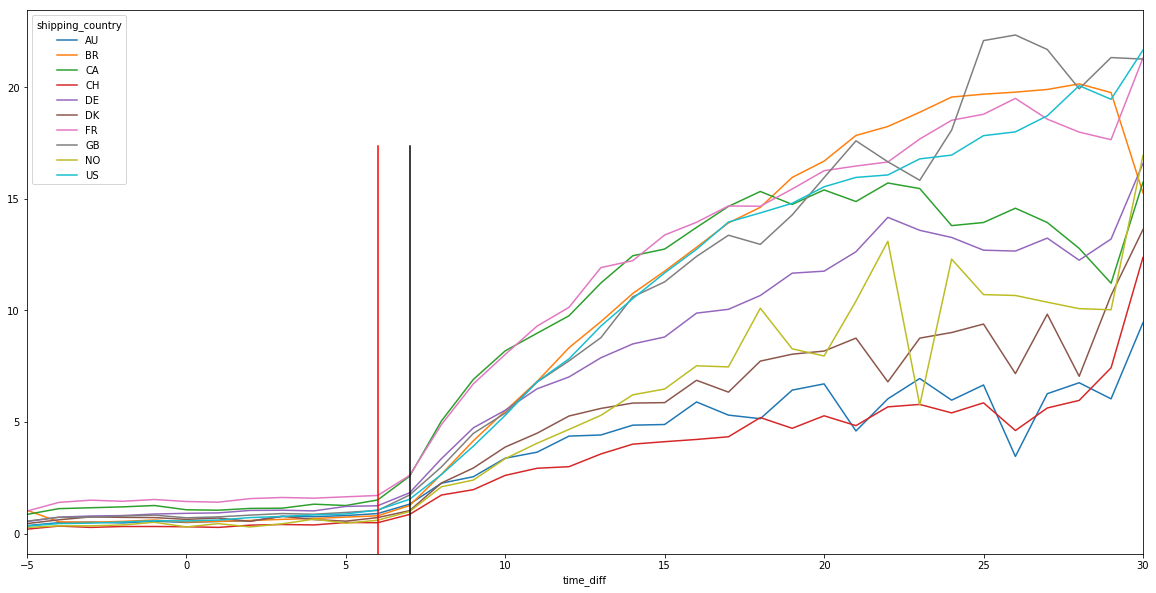

In [38]:
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
pvt = c.loc[c.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
pvt.plot(figsize=(20,10))
plt.axvline(7, 0, 0.75, color='black')
plt.axvline(6, 0, 0.75, color='red')

## Overall logistics refund rate: slice by month

In [118]:
# month_list = list(set(df.order_month))
month_list = ['2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03']
# a = month_list.sort()
# print(a)

<Figure size 432x288 with 0 Axes>

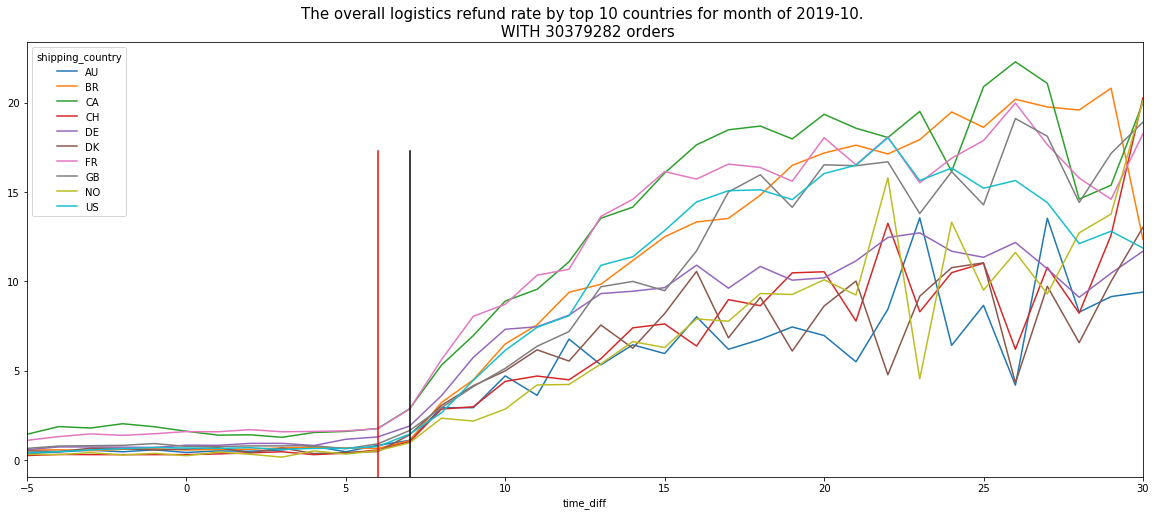

<Figure size 432x288 with 0 Axes>

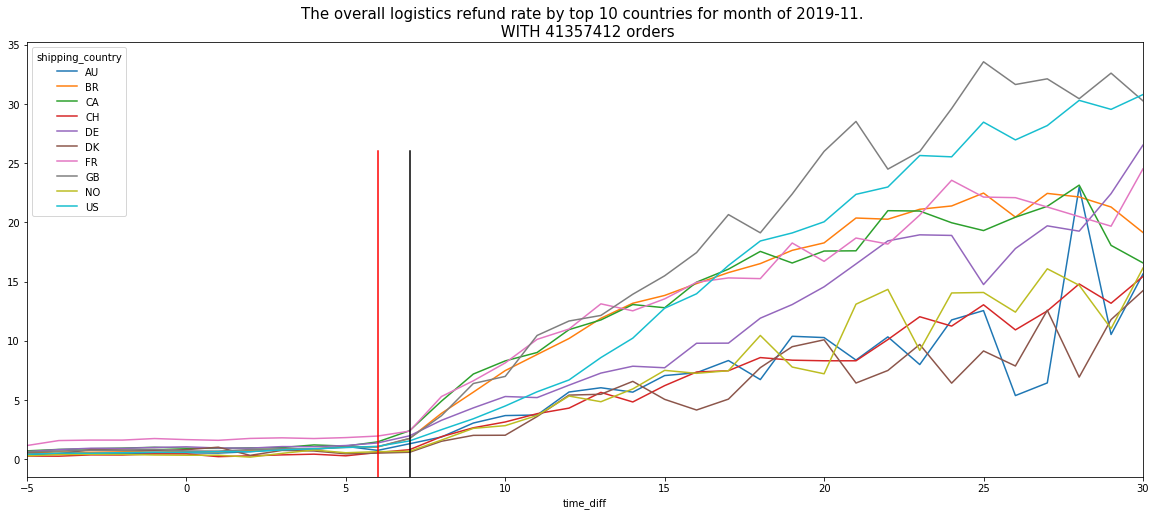

<Figure size 432x288 with 0 Axes>

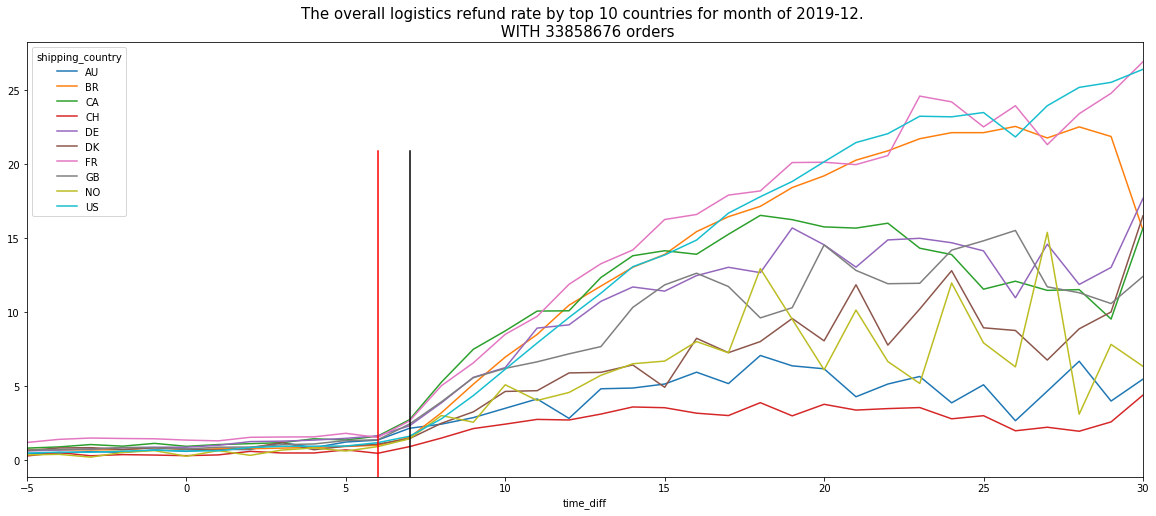

<Figure size 432x288 with 0 Axes>

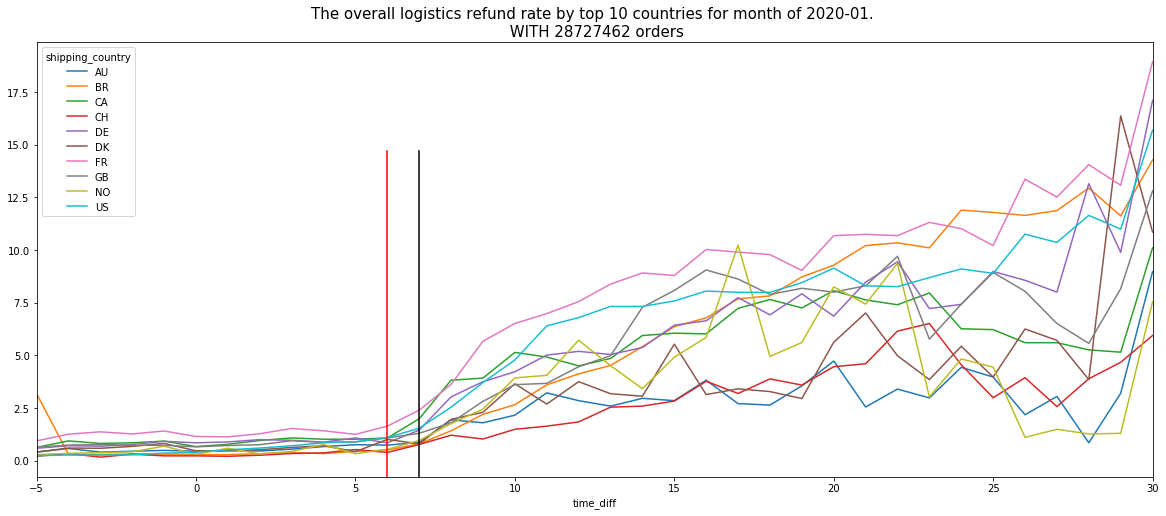

<Figure size 432x288 with 0 Axes>

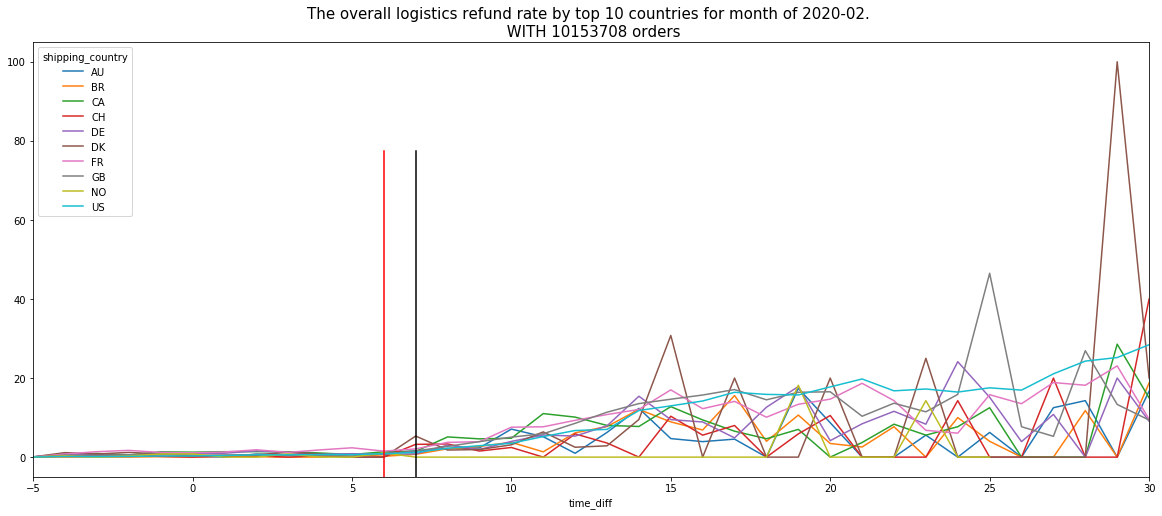

<Figure size 432x288 with 0 Axes>

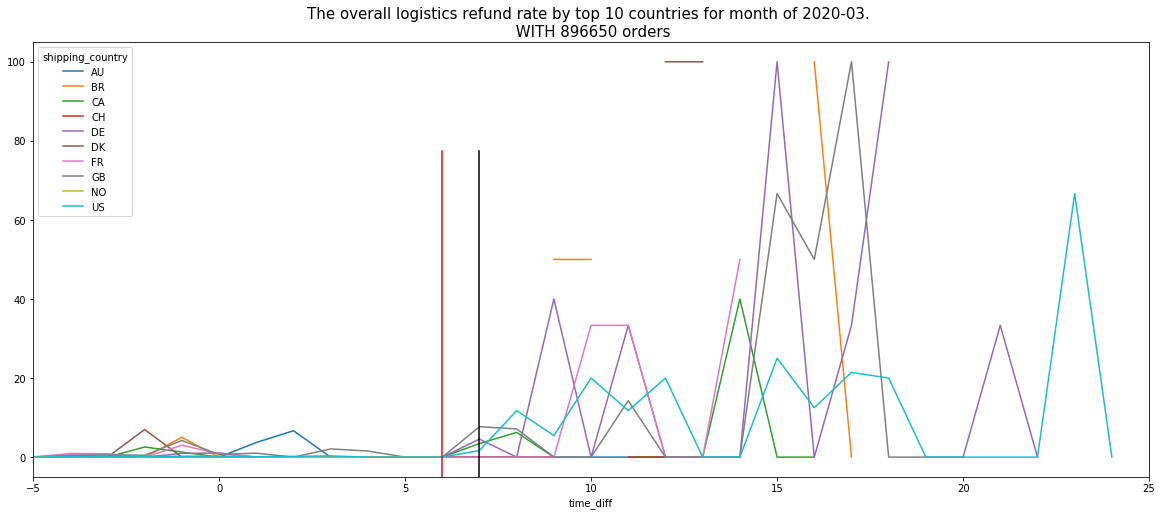

In [126]:
for month in month_list:
    df_month = df.loc[df.order_month==month,:].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
    df_month.loc[:, 'lrr'] = round(100*df_month.logistics_refund / df_month.transactions,2)
    df_month.loc[:, 'overall_rr'] = round(100*df_month.refunds / df_month.transactions,2)
    pvt = df_month.loc[df_month.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
    order_count = sum(df_month.transactions)
    
    plt.figure()
    pvt.plot(figsize=(20,8))
    plt.title('The overall logistics refund rate by top 10 countries for month of %s. \n WITH %s orders' %(month,order_count), size = 15)
    plt.axvline(7, 0, 0.75, color='black')
    plt.axvline(6, 0, 0.75, color='red')
    
    plt.show()

## Overall logistics refund rate: slice by registered mail or not

In [133]:
registered = list(set(df.registered))
registered

['false', 'true', 'Non Wishpost', None]

<Figure size 432x288 with 0 Axes>

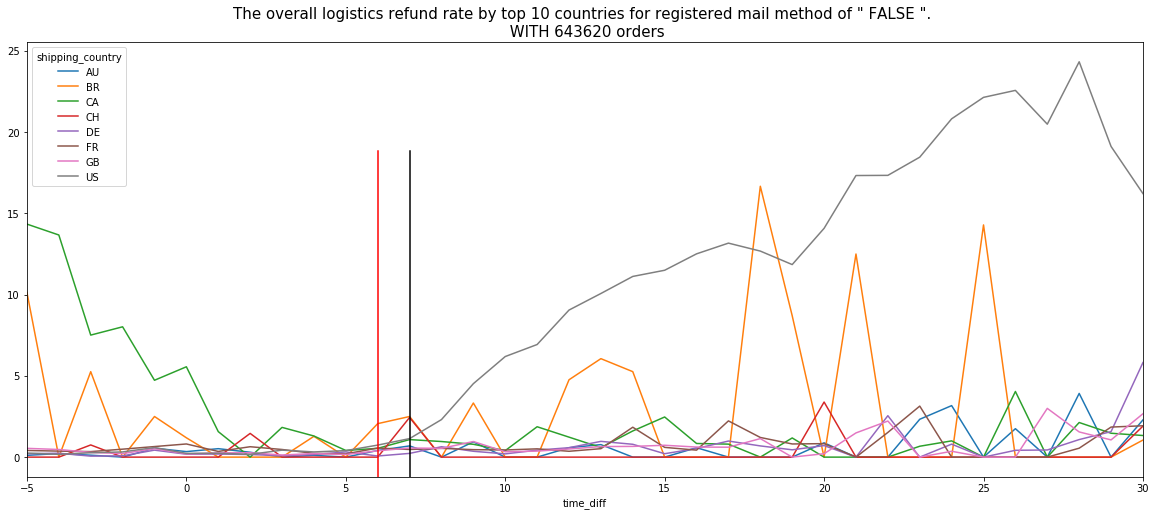

<Figure size 432x288 with 0 Axes>

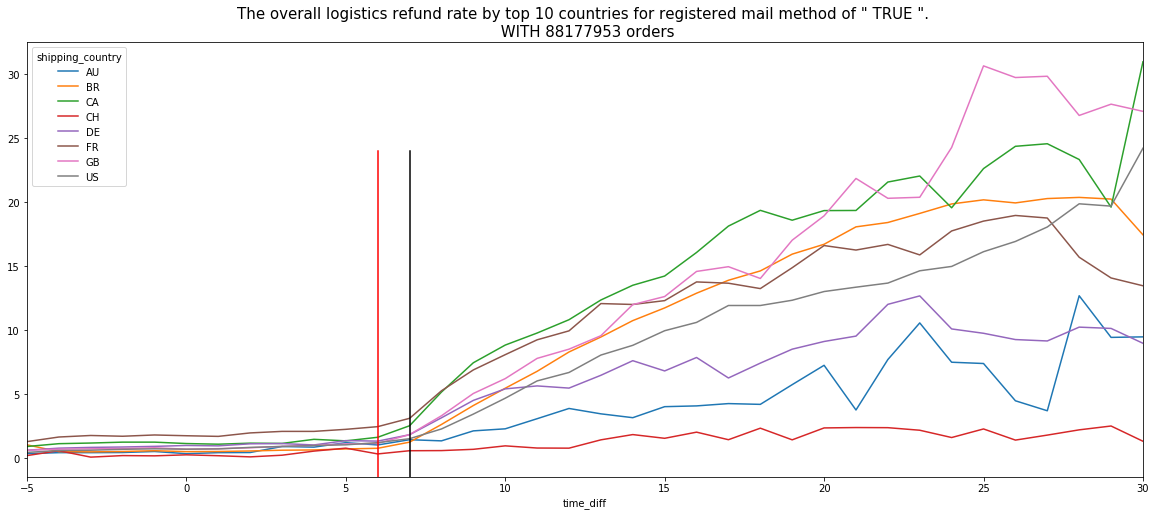

<Figure size 432x288 with 0 Axes>

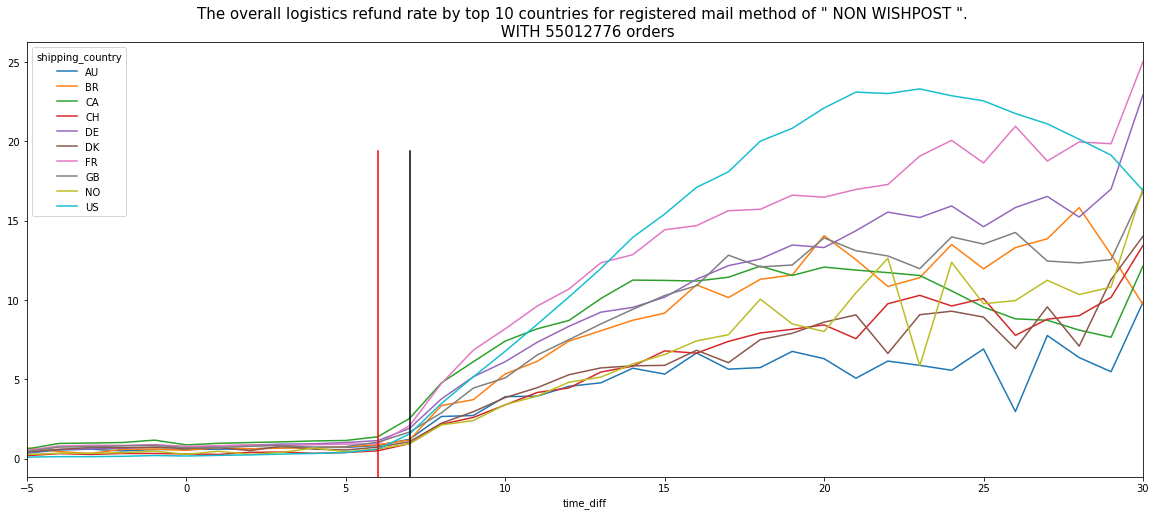

In [138]:
for register in registered[0:3]:
    df_month = df.loc[df.registered==register,:].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
    df_month.loc[:, 'lrr'] = round(100*df_month.logistics_refund / df_month.transactions,2)
    df_month.loc[:, 'overall_rr'] = round(100*df_month.refunds / df_month.transactions,2)
    pvt = df_month.loc[df_month.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
    order_count = sum(df_month.transactions)
    
    plt.figure()
    pvt.plot(figsize=(20,8))
    plt.title('The overall logistics refund rate by top 10 countries for registered mail method of " %s ". \n WITH %s orders' %(register.upper(),order_count), size = 15)
    plt.axvline(7, 0, 0.75, color='black')
    plt.axvline(6, 0, 0.75, color='red')
    
    plt.show()

## Overall logistics refund rate: slice by delivery program such as EPC, Dropship, A+ and so on

In [140]:
c = list(set(df.dim_delivery_program))
delivery_program

['A+', 'Wish_Express', 'EPC', 'Dropship', 'Fusion', 'FBW']

<Figure size 432x288 with 0 Axes>

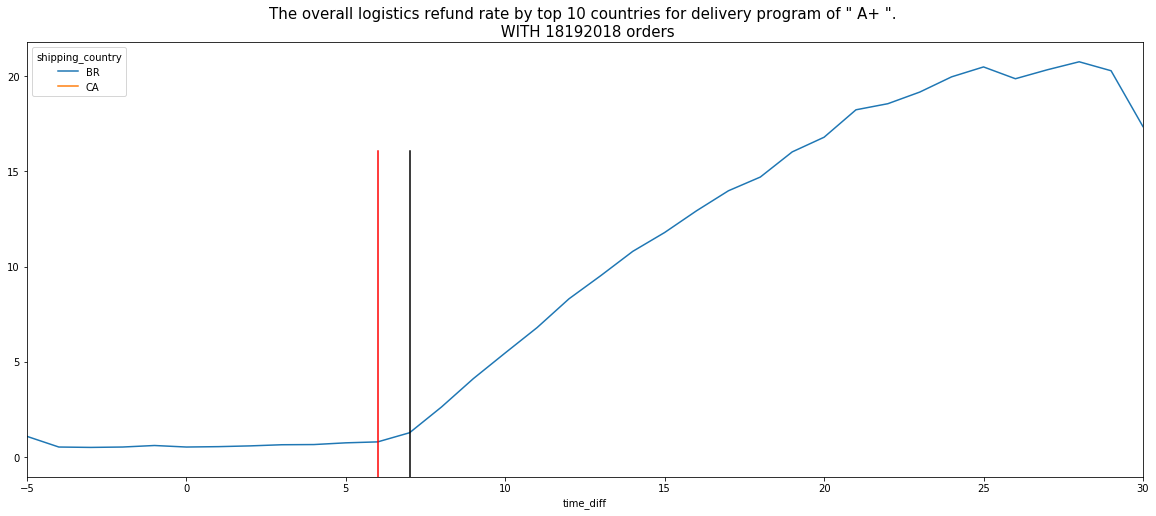

<Figure size 432x288 with 0 Axes>

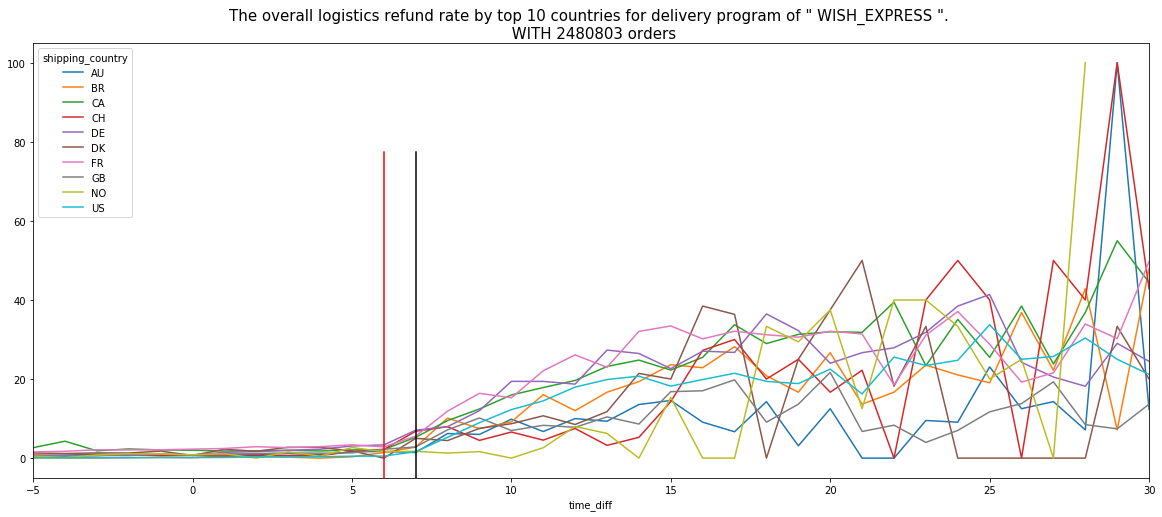

<Figure size 432x288 with 0 Axes>

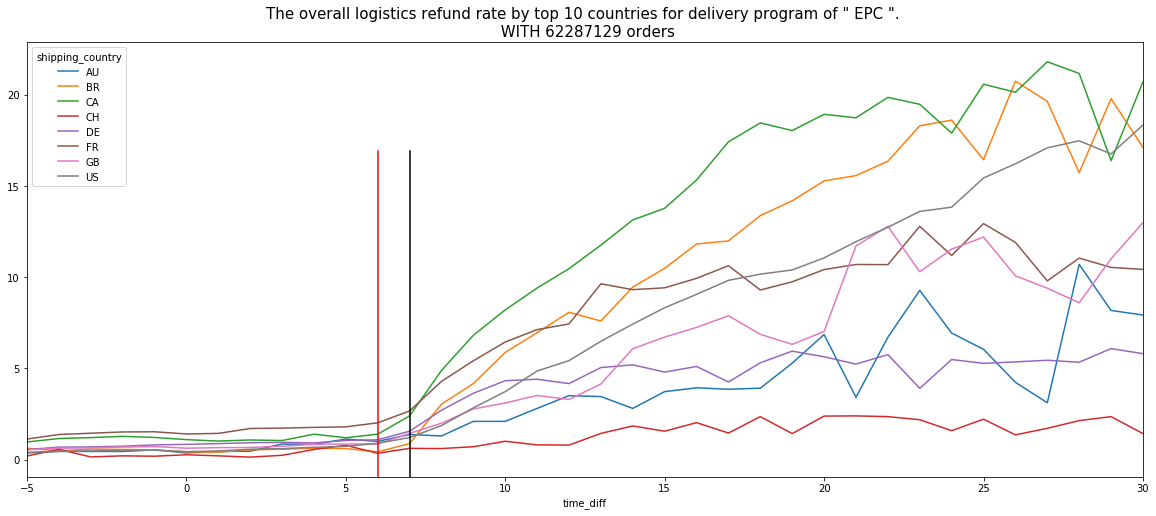

<Figure size 432x288 with 0 Axes>

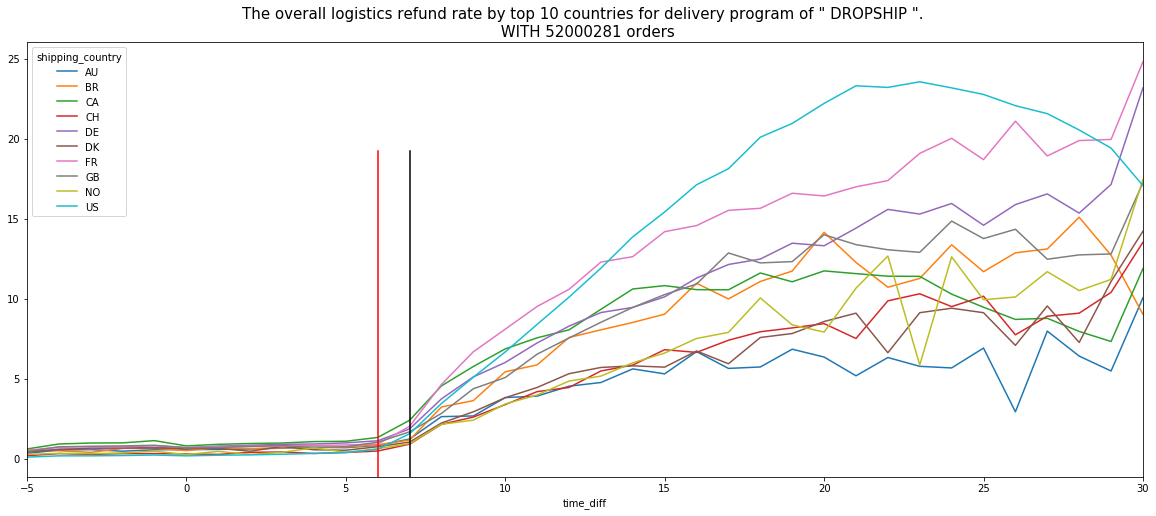

<Figure size 432x288 with 0 Axes>

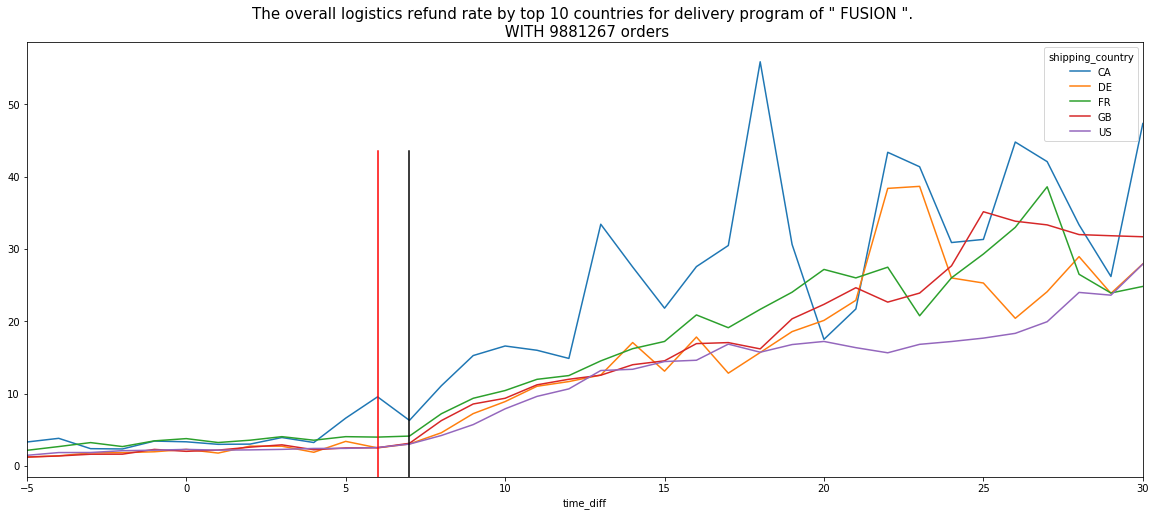

<Figure size 432x288 with 0 Axes>

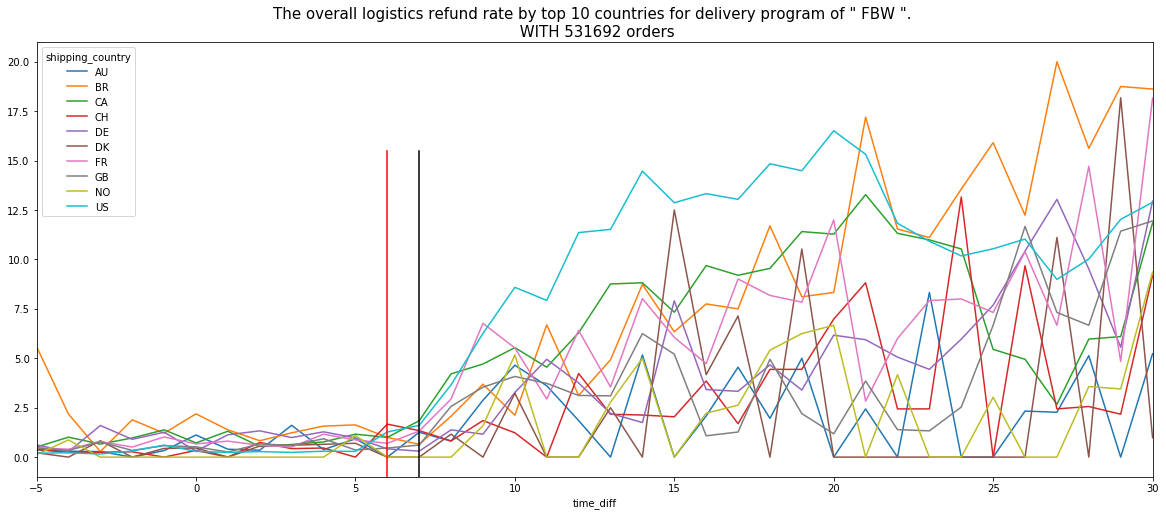

In [144]:
for delivery in delivery_program:
    df_month = df.loc[df.dim_delivery_program==delivery,:].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
    df_month.loc[:, 'lrr'] = round(100*df_month.logistics_refund / df_month.transactions,2)
    df_month.loc[:, 'overall_rr'] = round(100*df_month.refunds / df_month.transactions,2)
    pvt = df_month.loc[df_month.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
    order_count = sum(df_month.transactions)
    
    plt.figure()
    pvt.plot(figsize=(20,8))
    plt.title('The overall logistics refund rate by top 10 countries for delivery program of " %s ". \n WITH %s orders' %(delivery.upper(),order_count), size = 15)
    plt.axvline(7, 0, 0.75, color='black')
    plt.axvline(6, 0, 0.75, color='red')
    
    plt.show()